In [1]:
from pathlib import Path
import requests

import pickle
import gzip

from matplotlib import pyplot as plt
import numpy as np

import math

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as fxnl

In [2]:
# Data Setup

data_path = Path("dataset")
path = data_path / "mnist"
path.mkdir(parents=True, exist_ok=True)
url = "http://deeplearning.net/data/mnist/"
file_name = "mnist.pkl.gz"

if not (path / file_name).exists():
    content = requests.get(url= url + file_name).content
    (path / file_name).open("wb").write(content)

In [3]:
with gzip.open((path / file_name).as_posix(), "rb") as file:
    ((input_train, output_train), (input_valid, output_valid), _) = pickle.load(file= file, encoding="latin-1")
    

(50000, 784)


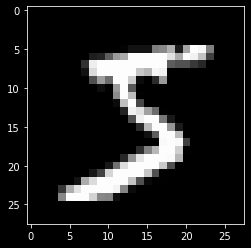

In [4]:
plt.imshow(input_train[0].reshape((28, 28)), cmap="gray")
print(input_train.shape)

In [5]:
d_type = torch.float
gpu_device = torch.device("cuda:0")

input_train, output_train, input_valid, output_valid = map(torch.tensor, (input_train, output_train, input_valid, output_valid))

# Convert to GPU Tensors
input_train, output_train, input_valid, output_valid = input_train.to(gpu_device), output_train.to(gpu_device), input_valid.to(gpu_device), output_valid.to(gpu_device)

rows, cols = input_train.shape

input_train, input_train.shape, output_train.min(), output_train.max()

print(input_train, output_train)
print()
print(input_train.shape)
print()
print(output_train.min(), output_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0') tensor([5, 0, 4,  ..., 8, 4, 8], device='cuda:0')

torch.Size([50000, 784])

tensor(0, device='cuda:0') tensor(9, device='cuda:0')


In [30]:
# NN from scratch without torch.nm

weights = torch.randn(784, 10).to(gpu_device) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True).to(gpu_device)

def log_softmax(input_tensor : torch.Tensor):
    return input_tensor.to(gpu_device) - input_tensor.exp().sum(-1).log().unsqueeze(-1).to(gpu_device)

def model(xb):
    input = (xb @ weights) + bias
    return log_softmax(input.to(gpu_device))

In [7]:
batxh_size = 64
xb = input_train[0:batxh_size]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5099, -2.0542, -2.6354, -2.6747, -1.7126, -2.6422, -2.4948, -2.5564,
        -2.5390, -1.8371], device='cuda:0', grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
def negative_log_likelihood(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_fxn = negative_log_likelihood

yb= output_train[0:batxh_size]
print(loss_fxn(preds, yb))

tensor(2.4031, device='cuda:0', grad_fn=<NegBackward>)


In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0312, device='cuda:0')


In [31]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((rows - 1) // batxh_size + 1):
        #         set_trace()
        start_i = i * batxh_size
        end_i = start_i + batxh_size
        xb = input_train[start_i:end_i]
        yb = output_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fxn(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            print(bias, bias.grad)
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<CopyBackwards>) None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'